In [1]:
import jax.numpy as jnp
import numpy as np
import pyccl as ccl
import pyccl.halos as halos
import matplotlib.pylab as plt

from jax_cosmo.core import Cosmology
import jax_cosmo.power as jcp
from jax_cosmo.halos.hmbase import compute_sigma, calculate_mass_function
from jax_cosmo.halos.hmfunc import JAXMassFuncBocquet16

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 12

jcp.USE_EMU = True

In [2]:
cosmo_jax = Cosmology(Omega_c=0.2650,
                      Omega_b=0.0492,
                      h=0.6724,
                      sigma8 = 0.811,
                      n_s=0.9645,
                      Omega_k=0.,
                      w0=-1.,
                      wa=0.,
                     Neff = 3.044)

cosmo_ccl = ccl.Cosmology(Omega_c=0.2650,
                          Omega_b=0.0492,
                          h=0.6724,
                          sigma8 = 0.811,
                          n_s=0.9645,
                          Neff = 3.044,
                          transfer_function='eisenstein_hu',
                          matter_power_spectrum='halofit')

## Halo Mass Function

In [3]:
interpolator = compute_sigma(cosmo_jax)

In [4]:
m_arr = jnp.geomspace(1.01E12,1E15,128) / cosmo_ccl['h']
z_grid = jnp.linspace(0, 1, 10)

In [5]:
# JAXMassFuncAngulo12()
# JAXMassFuncBocquet16()
# JAXMassFuncDespali16()
# JAXMassFuncTinker08()
# JAXMassFuncTinker10()
# JAXMassFuncWatson13() -> In CCL: halos.MassFuncWatson13(mass_def=ccl.halos.MassDefFof)
# JAXMassFuncSheth99()
# JAXMassFuncPress74()
# JAXMassFuncJenkins01()

jax_hm_func = JAXMassFuncBocquet16()
ccl_hm_func = halos.MassFuncBocquet16()

record_mf_ccl = []
record_mf_jax = []

for z in z_grid:
    a = 1.0 / (1.0 + z)
    mf_ccl = ccl_hm_func(cosmo_ccl, m_arr, a.item())
    mf_jax, _ = calculate_mass_function(cosmo_jax, m_arr, a, jax_hm_func, interpolator)
    record_mf_ccl.append(mf_ccl)
    record_mf_jax.append(mf_jax)

record_mf_ccl = jnp.asarray(record_mf_ccl).T
record_mf_jax = jnp.asarray(record_mf_jax).T

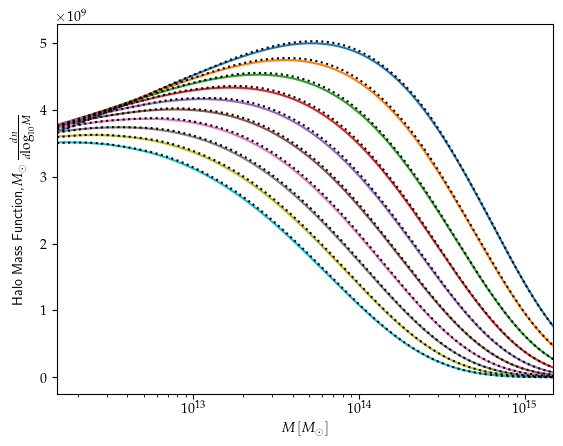

In [6]:
plt.plot(m_arr, m_arr.reshape(-1,1) * record_mf_ccl)
plt.plot(m_arr, m_arr.reshape(-1,1) * record_mf_jax, linestyle = ':', color = 'k')
plt.ylabel(r'Halo Mass Function,' + r'$M_{\odot}\,\frac{dn}{d\textrm{log}_{10}M}$')
plt.xlabel(r'$M\,[M_{\odot}]$')
plt.xlim(min(m_arr), max(m_arr))
plt.xscale('log')
plt.show()

## Halo Bias

In [7]:
from jax_cosmo.halos.hmbase import get_logM_sigM
from jax_cosmo.halos.hmbias import HaloBiasBhattacharya11

In [8]:
ccl_halo_bias = halos.HaloBiasBhattacharya11()
jax_halo_bias = HaloBiasBhattacharya11()

record_bias_ccl = []
record_bias_jax = []

for z in z_grid:
    a = 1.0 / (1.0 + z)
    bias_ccl = ccl_halo_bias(cosmo_ccl, m_arr, a.item())

    # we need to compute \sigma_M for a given mass
    log_mass, sigma_mass, dlns_dlogM = get_logM_sigM(cosmo_jax, m_arr, a.item(), interpolator)
    bias_jax = jax_halo_bias.compute_bias(cosmo_jax, sigma_mass, a.item())

    record_bias_ccl.append(bias_ccl)
    record_bias_jax.append(bias_jax)

In [9]:
record_bias_ccl = jnp.asarray(record_bias_ccl)
record_bias_jax = jnp.asarray(record_bias_jax)

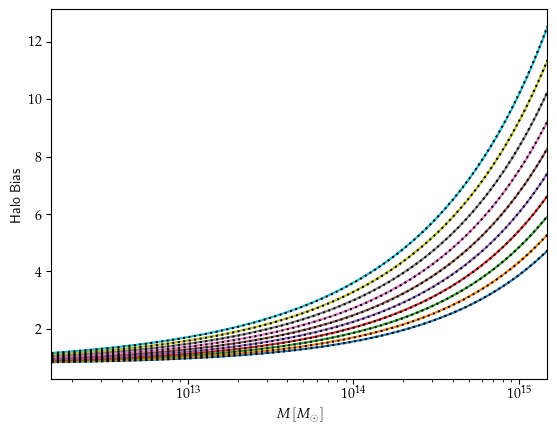

In [10]:
plt.plot(m_arr, record_bias_ccl.T)
plt.plot(m_arr, record_bias_jax.T, c = 'k', linestyle = ':')
plt.ylabel(r'Halo Bias')
plt.xlabel(r'$M\,[M_{\odot}]$')
plt.xlim(min(m_arr), max(m_arr))
plt.xscale('log')
plt.show()

## Concentration

In [11]:
from pyccl.halos.concentration import ConcentrationDuffy08
from jax_cosmo.halos.concentration import JAXConDuffy08

In [12]:
record_conc_ccl = []
record_conc_jax = []

conc_ccl = ConcentrationDuffy08()
conc_jax = JAXConDuffy08()

for z in z_grid:
    a = 1.0 / (1.0 + z)
    concenctration_ccl = conc_ccl(cosmo_ccl, m_arr, a.item())
    concenctration_jax = conc_jax.compute_concentration(cosmo_jax, m_arr, a.item(), interpolator)

    record_conc_ccl.append(concenctration_ccl)
    record_conc_jax.append(concenctration_jax)

In [13]:
record_conc_ccl = jnp.asarray(record_conc_ccl)
record_conc_jax = jnp.asarray(record_conc_jax)

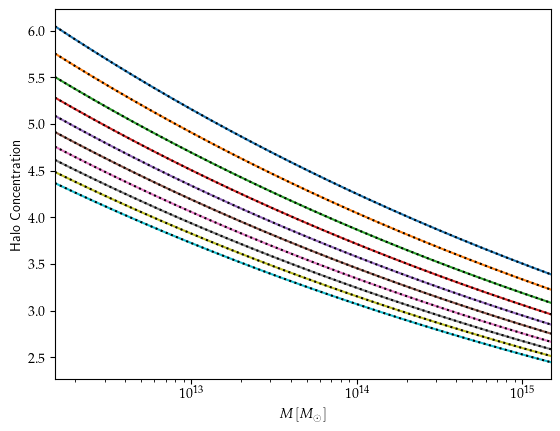

In [14]:
plt.figure()
plt.plot(m_arr, record_conc_ccl.T)
plt.plot(m_arr, record_conc_jax.T, c = 'k', linestyle = ':')
plt.ylabel(r'Halo Concentration')
plt.xlabel(r'$M\,[M_{\odot}]$')
plt.xlim(min(m_arr), max(m_arr))
plt.xscale('log')
plt.show()

## Sine and Cosine Integral

The $si(x)$ (sine integral) and $ci(x)$ (cosine integral) are missing in JAX. We implement them here. For small values ($x<10$), we compute the integration numerically. For large values ($x\ge 10$), the integration can be unstable and we use the following approximations (which work quite well):

$$
C = \dfrac{\textrm{cos}\,x}{x}\left(1-\dfrac{2!}{x^{2}}+\dfrac{4!}{x^{4}}-\dfrac{6!}{x^{6}}\ldots\right)
$$

$$
S = \dfrac{\textrm{sin}\,x}{x}\left(\dfrac{1}{x}-\dfrac{3!}{x^{3}}+\dfrac{5!}{x^{5}}-\dfrac{7!}{x^{7}}\ldots\right)
$$

Then, 

$$
si(x) = \dfrac{\pi}{2}-C-S
$$

$$
ci(x) = S-C
$$

For $x<10$ (threshold we choose here):

$$
si(x) = \int_{0}^{x}\dfrac{\textrm{sin}\,t}{t}\,\textrm{d}t
$$

$$
ci(x) = \gamma + \textrm{log}(x) + \int_{0}^{x}\dfrac{\textrm{cos}\,t-1}{t}\,\textrm{d}t
$$

where $\gamma\approx 0.57721566490$ is the Euler–Mascheroni constant.

In [15]:
from scipy.special import sici
from jax_cosmo.scipy.special import compute_sici

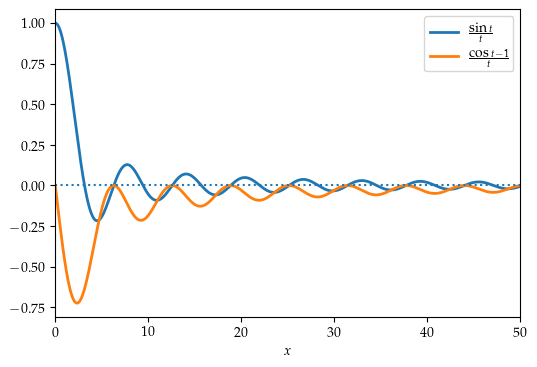

In [16]:
xmax = 50
domain = jnp.linspace(1E-5, xmax, 1000)
f_sin = jnp.sin(domain)/domain
f_cos = (jnp.cos(domain) - 1.0)/domain

plt.figure(figsize=(6,4))
plt.plot(domain, f_sin, lw=2, label = r'$\frac{\textrm{sin}\,t}{t}$')
plt.plot(domain, f_cos, lw=2, label = r'$\frac{\textrm{cos}\,t-1}{t}$')
plt.axhline(0.0, linestyle = ':')
plt.xlabel(r'$x$')
plt.xlim(0, xmax)
plt.legend()
plt.show()

In [17]:
testpoints = np.linspace(1E-3, 100, 1000)
scipy_si, scipy_ci = sici(testpoints)
jc_si, jc_ci = compute_sici(testpoints)

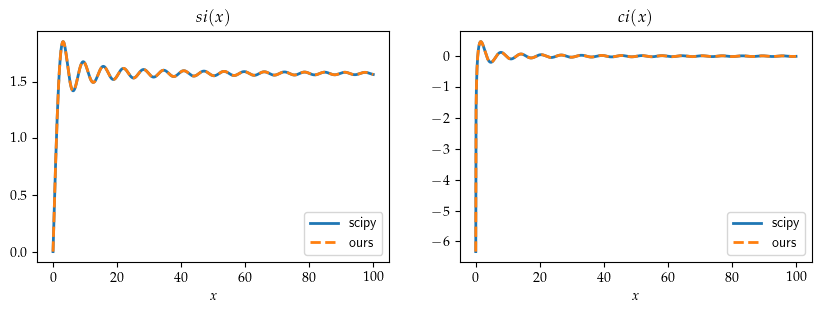

In [29]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.title(r'$si(x)$')
plt.plot(testpoints, scipy_si, lw = 2, label ='scipy')
plt.plot(testpoints, jc_si, lw=2, linestyle='--', label = 'ours')
plt.xlabel(r'$x$')
plt.legend()
plt.subplot(122)
plt.title(r'$ci(x)$')
plt.plot(testpoints, scipy_ci, lw = 2, label ='scipy')
plt.plot(testpoints, jc_ci, lw=2, linestyle='--', label = 'ours')
plt.xlabel(r'$x$')
plt.legend()
plt.show()

## Halo Profile

In [11]:
from jax_cosmo.halos.profiles.nfw import JAXHaloProfileNFW
from jax_cosmo.halos.profiles.hernquist import JAXHaloProfileHernquist
from jax_cosmo.halos.profiles.einasto import JAXHaloProfileEinasto
from jax_cosmo.halos.hmbase import MassDefinition
from jax_cosmo.halos.concentration import JAXConDuffy08

In [12]:
# Radius, wavenumber and mass
r_arr = np.geomspace(1E-2,1E2,256)
k_arr = np.geomspace(1E-2,1E2,256)
m_arr = np.geomspace(1E11,1E15,32)

# We will calculate everything at z=1 (scale factor = 0.5)
a_sf = 0.5

# We will also use a mass definition with Delta = 200, and the Duffy 2008 concentration-mass relation
hmd_200c = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200c)

hmd_200c_jax = MassDefinition(200, "critical")
conc_jax = JAXConDuffy08()

### Real Profile

In [16]:
ccl_nfw = ccl.halos.HaloProfileNFW(mass_def=hmd_200c, concentration=cM, truncated=False)
ccl_hq = ccl.halos.HaloProfileHernquist(mass_def=hmd_200c, concentration=cM, truncated=False)
ccl_en = ccl.halos.HaloProfileEinasto(mass_def=hmd_200c, concentration=cM, truncated=False)

ccl_nfw_real = ccl_nfw.real(cosmo_ccl, r_arr, 1E14, a_sf)
ccl_hq_real = ccl_hq.real(cosmo_ccl, r_arr, 1E14, a_sf)
ccl_en_real = ccl_en.real(cosmo_ccl, r_arr, 1E14, a_sf)

In [17]:
jax_nfw = JAXHaloProfileNFW(hmd_200c_jax, conc_jax, truncated=False)
jax_hq = JAXHaloProfileHernquist(hmd_200c_jax, conc_jax, truncated=False)
jax_en = JAXHaloProfileEinasto(hmd_200c_jax, conc_jax, truncated=False)

jax_nfw_real = jax_nfw._real(cosmo_jax, r_arr, 1E14, a_sf, interpolator)
jax_hq_real = jax_hq._real(cosmo_jax, r_arr, 1E14, a_sf, interpolator)
jax_en_real = jax_en._real(cosmo_jax, r_arr, 1E14, a_sf, interpolator)

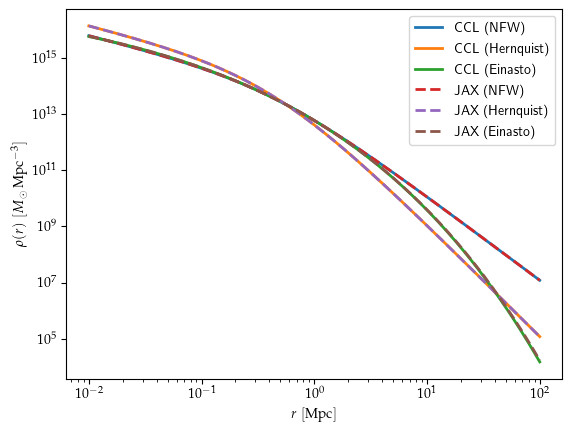

In [18]:
plt.loglog(r_arr, ccl_nfw_real, lw =2, label = 'CCL (NFW)')
plt.loglog(r_arr, ccl_hq_real, lw =2, label = 'CCL (Hernquist)')
plt.loglog(r_arr, ccl_en_real, lw =2, label = 'CCL (Einasto)')

plt.loglog(r_arr, jax_nfw_real, linestyle = '--', lw=2, label = 'JAX (NFW)')
plt.loglog(r_arr, jax_hq_real, linestyle = '--', lw=2, label = 'JAX (Hernquist)')
plt.loglog(r_arr, jax_en_real, linestyle = '--', lw=2, label = 'JAX (Einasto)')

plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$')
plt.xlabel(r'$r\,\,[{\rm Mpc}]$')
plt.legend()
plt.show()

### Fourier Profile

In [19]:
ccl_nfw_fourier = ccl_nfw.fourier(cosmo_ccl, k_arr, 1E14, a_sf)
jax_nfw_fourier = jax_nfw._fourier_analytic(cosmo_jax, k_arr, 1E14, a_sf, interpolator)

ccl_hq_fourier = ccl_hq.fourier(cosmo_ccl, k_arr, 1E14, a_sf)
jax_hq_fourier = jax_hq._fourier_analytic(cosmo_jax, k_arr, 1E14, a_sf, interpolator)

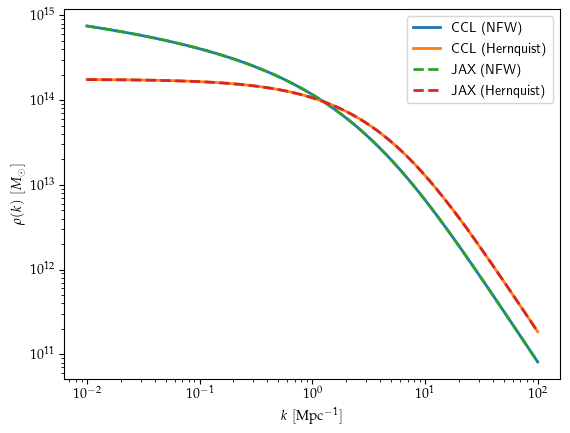

In [20]:
plt.loglog(k_arr, ccl_nfw_fourier, lw =2, label = 'CCL (NFW)')
plt.loglog(k_arr, ccl_hq_fourier, lw =2, label = 'CCL (Hernquist)')

plt.loglog(k_arr, jax_nfw_fourier, linestyle = '--', lw=2, label = 'JAX (NFW)')
plt.loglog(k_arr, jax_hq_fourier, linestyle = '--', lw=2, label = 'JAX (Hernquist)')

plt.ylabel(r'$\rho(k)\,\,[M_\odot]$')
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$')
plt.legend()
plt.show()

### Projected quad for Einasto

To check these two

In [29]:
ccl_en_proj_quad = ccl_en._projected_quad(cosmo_ccl, r_arr, 1E14, a_sf)

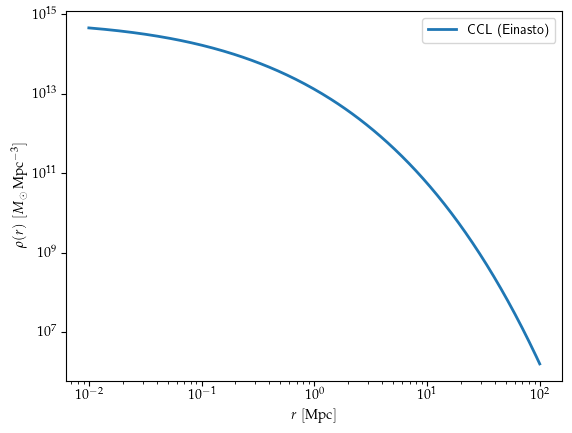

In [30]:
plt.loglog(r_arr, ccl_en_proj_quad, lw =2, label = 'CCL (Einasto)')
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$')
plt.xlabel(r'$r\,\,[{\rm Mpc}]$')
plt.legend()
plt.show()

In [ ]:
# jax_en._projected_quad(cosmo_jax, r_arr, 1E14, a_sf, interpolator)